In [138]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

In [5]:
#theme
sns.set_style('whitegrid')
sns.set_palette('crest')

## Data Overview

In [6]:
#load the dataset
df = pd.read_csv('diabetes_prediction_dataset.csv')

In [7]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [8]:
df.shape

(100000, 9)

In [9]:
df.dtypes

gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

## Data Cleaning

In [10]:
#checking for missing values
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

checking unique values

In [12]:
df.nunique()

gender                    3
age                     102
hypertension              2
heart_disease             2
smoking_history           6
bmi                    4247
HbA1c_level              18
blood_glucose_level      18
diabetes                  2
dtype: int64

In [13]:
df['gender'].unique()

array(['Female', 'Male', 'Other'], dtype=object)

In [14]:
df['gender'].value_counts()

gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64

In [15]:
df['smoking_history'].unique()

array(['never', 'No Info', 'current', 'former', 'ever', 'not current'],
      dtype=object)

In [16]:
#checking for duplicates
df.duplicated().sum()

3854

In [17]:
df[df.duplicated()]

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
2756,Male,80.0,0,0,No Info,27.32,6.6,159,0
3272,Female,80.0,0,0,No Info,27.32,3.5,80,0
3418,Female,19.0,0,0,No Info,27.32,6.5,100,0
3939,Female,78.0,1,0,former,27.32,3.5,130,0
3960,Male,47.0,0,0,No Info,27.32,6.0,200,0
...,...,...,...,...,...,...,...,...,...
99980,Female,52.0,0,0,never,27.32,6.1,145,0
99985,Male,25.0,0,0,No Info,27.32,5.8,145,0
99989,Female,26.0,0,0,No Info,27.32,5.0,158,0
99990,Male,39.0,0,0,No Info,27.32,6.1,100,0


In [18]:
#dropping duplicates
df = df.drop_duplicates().reset_index(drop=True)

In [19]:
#confirming there's no duplicates 
df.duplicated().sum()

0

In [20]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000
mean,41.794326,0.077601,0.040803,27.321461,5.532609,138.218231,0.088220
std,22.462948,0.267544,0.197833,6.767716,1.073232,40.909771,0.283616
min,0.080000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.000000,0.000000,23.400000,4.800000,100.000000,0.000000
50%,43.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,59.000000,0.000000,0.000000,29.860000,6.200000,159.000000,0.000000
max,80.000000,1.000000,1.000000,95.690000,9.000000,300.000000,1.000000


Handling Outliers

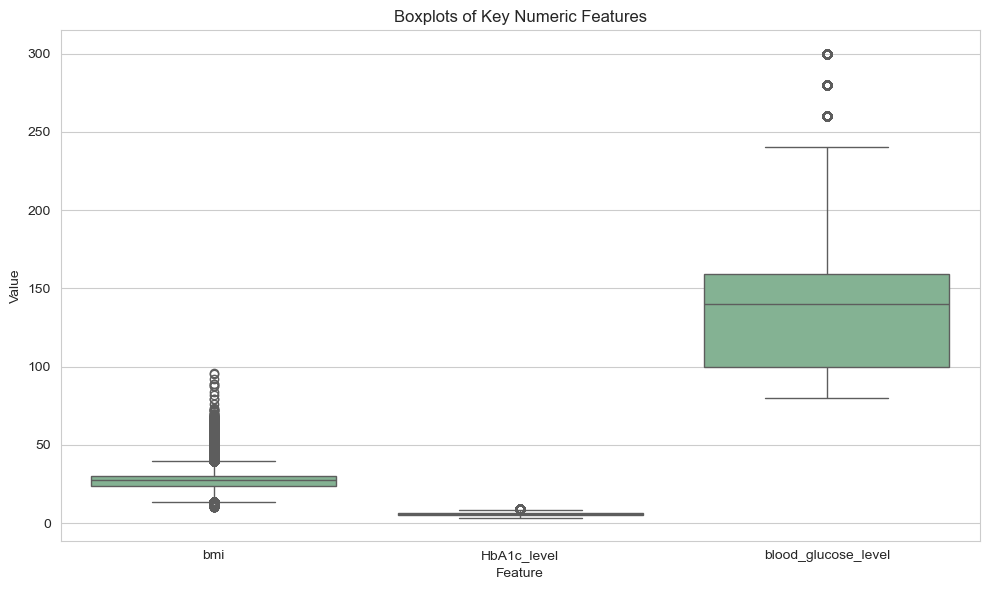

In [168]:
#checking outliers
melted = df[['bmi', 'HbA1c_level', 'blood_glucose_level']].melt(var_name='Feature', value_name='Value')

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Feature', y='Value', data=melted)
plt.title('Boxplots of Key Numeric Features')
plt.tight_layout()
plt.savefig('visuals/boxplots_numeric_features.png')
plt.show()

Since we are working with medical data, I'd rather flag outliers than cap them. In medical data, they may represent real clinical concern, not errors


In [24]:
#flagging outliers
def flag_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[f'{column}_outlier'] = ~df[column].between(lower_bound, upper_bound)
    return df

for col in ['bmi', 'HbA1c_level', 'blood_glucose_level']:
    df = flag_outliers_iqr(df, col)

---

## Exploratory Data Analysis (EDA)

Distributions

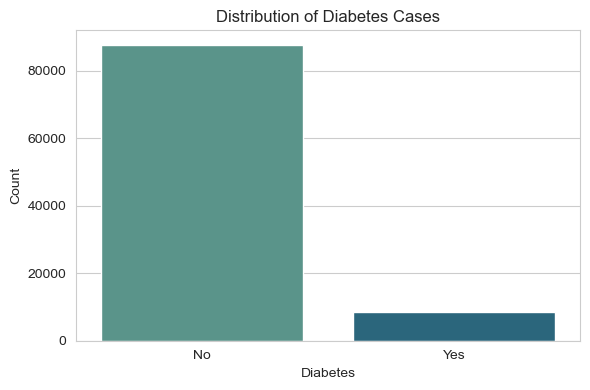

In [27]:
# diabetes distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='diabetes', data=df, hue='diabetes', palette='crest', legend=False)
plt.title('Distribution of Diabetes Cases')
plt.xlabel('Diabetes')
plt.ylabel('Count')
plt.xticks([0, 1], ['No', 'Yes'])
plt.tight_layout()
plt.savefig('visuals/diabetes_distribution.png')
plt.show()

In [28]:
df['diabetes'].value_counts()


diabetes
0    87664
1     8482
Name: count, dtype: int64

In [29]:
print(df['diabetes'].unique())

[0 1]


In [30]:
print(df['diabetes'].value_counts(normalize=True))

diabetes
0    0.91178
1    0.08822
Name: proportion, dtype: float64


In [31]:
df['diabetes'].value_counts(normalize=True).sum()  # Should return 1.0


1.0

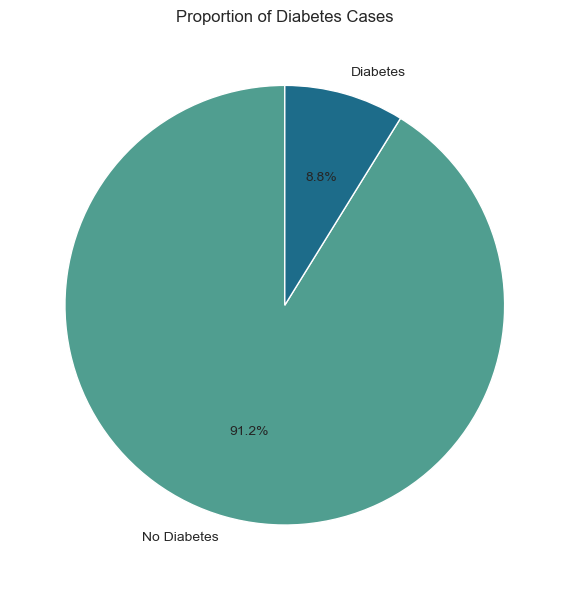

In [32]:
#diabetes distribution pie
diabetes_counts = df['diabetes'].value_counts()
labels = ['No Diabetes', 'Diabetes']
colors = sns.color_palette('crest', n_colors=2)

# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(diabetes_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Proportion of Diabetes Cases')
plt.tight_layout()
plt.savefig('visuals/diabetes_pie_chart.png')
plt.show()

In [33]:
#creating a copy of the dataset with binary values to categorical values ('Yes'/'No') for more intuitive EDA visualizations

df_plot = df.copy()
df_plot['heart_disease'] = df_plot['heart_disease'].map({0: 'No', 1: 'Yes'})
df_plot['hypertension'] = df_plot['hypertension'].map({0: 'No', 1: 'Yes'})
df_plot['diabetes'] = df_plot['diabetes'].map({0: 'No', 1: 'Yes'})

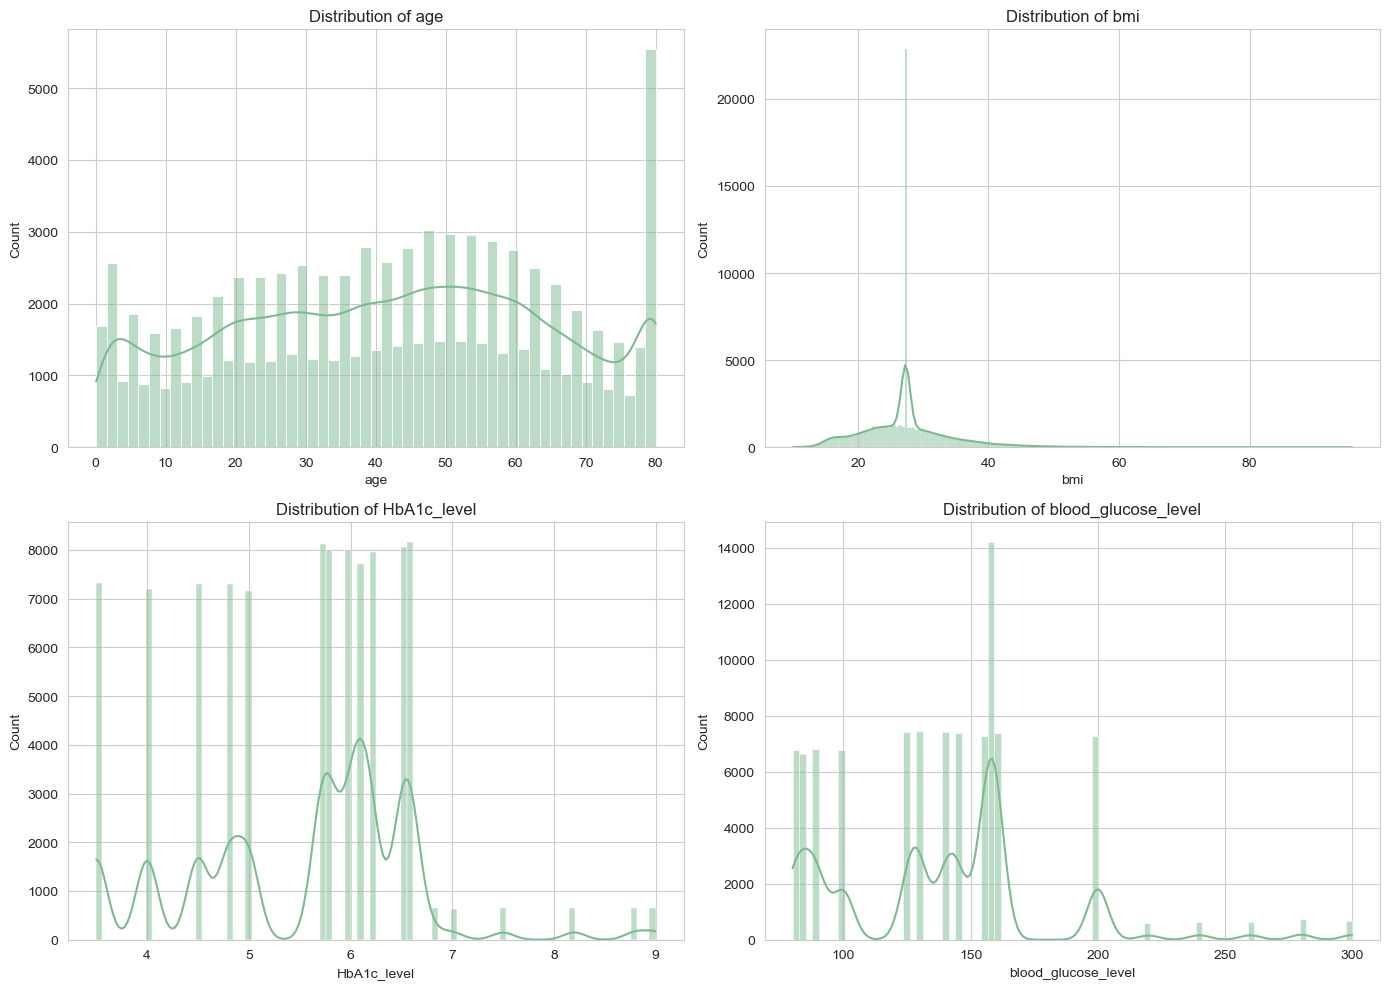

In [34]:
#numeric distribution
numeric_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

plt.figure(figsize=(14, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.savefig('visuals/numeric_distributions.png')
plt.show()

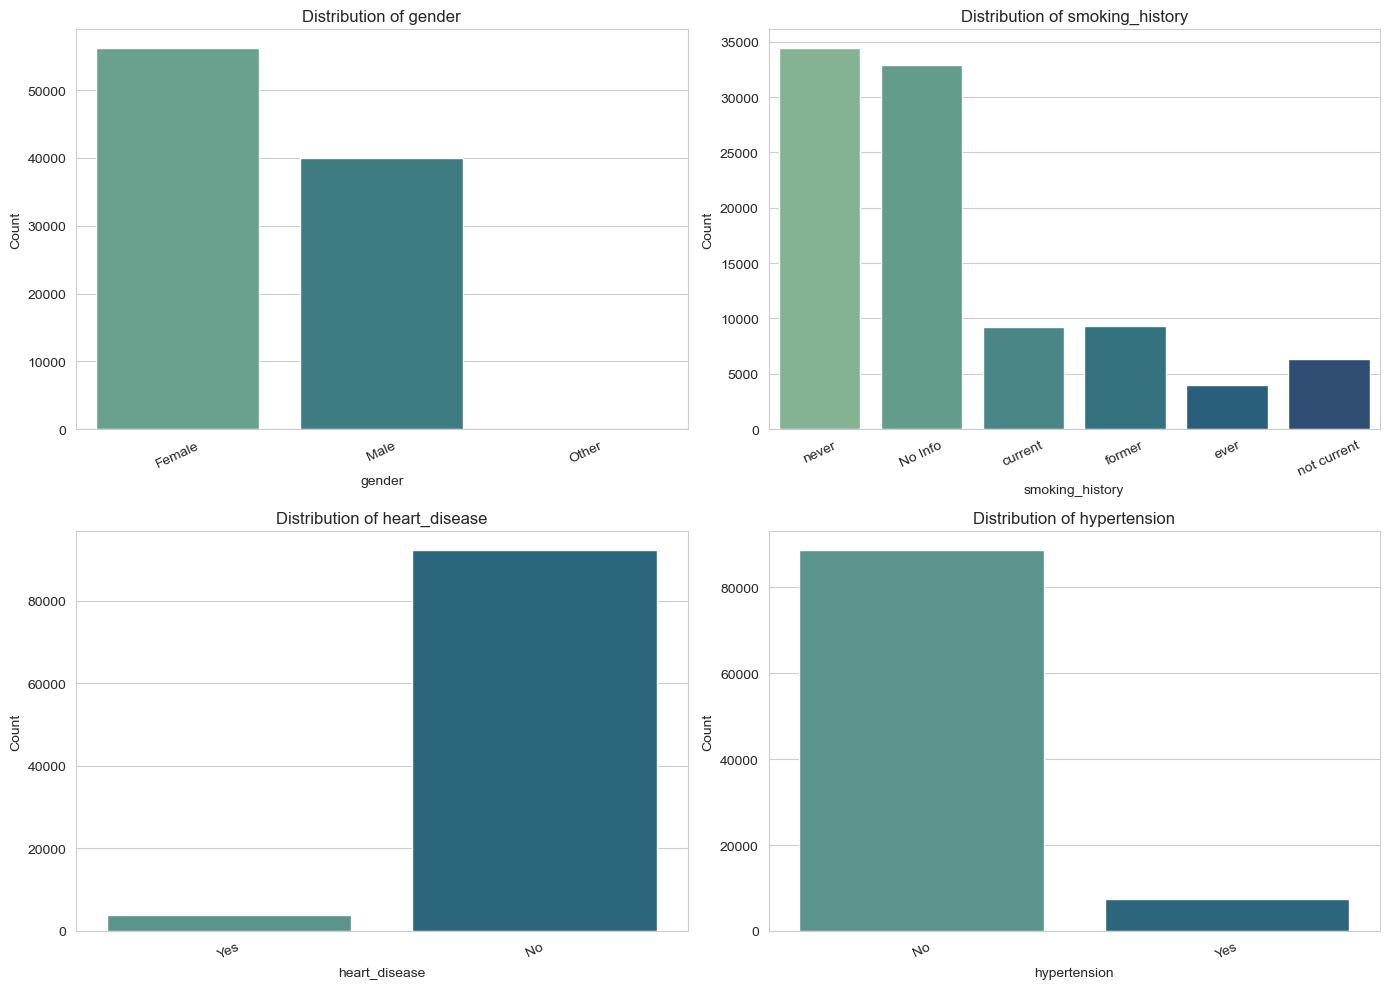

In [35]:
#categorical distributions
categorical_cols = ['gender', 'smoking_history', 'heart_disease', 'hypertension']

plt.figure(figsize=(14, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=col, data=df_plot, hue=col, palette='crest', legend=False)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=25)
plt.tight_layout()
plt.savefig('visuals/categorical_distributions.png')
plt.show()

Variables VS Target

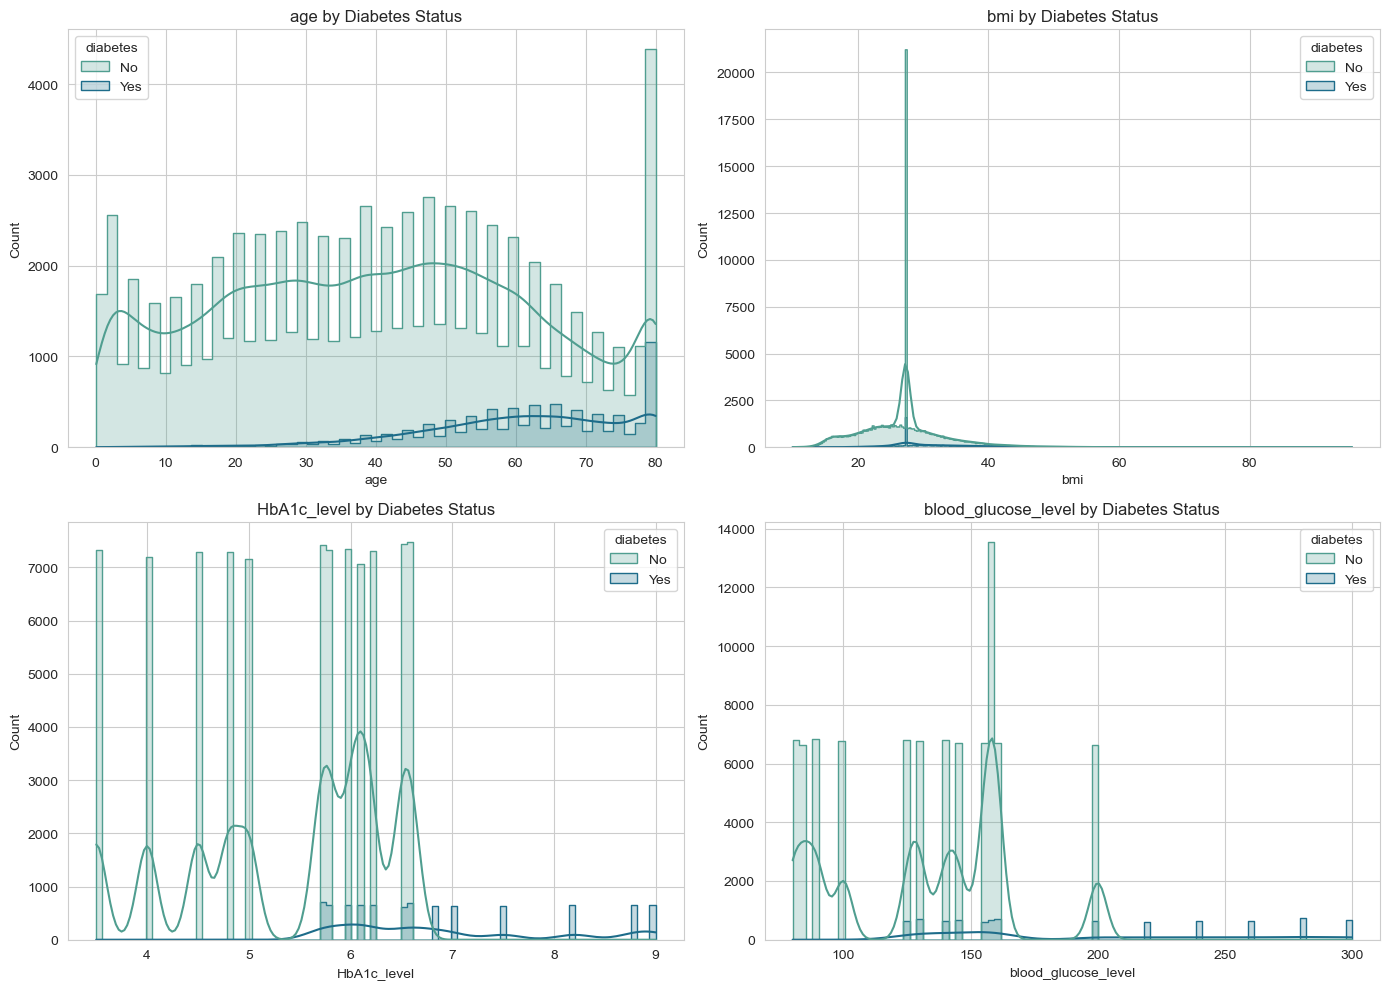

In [37]:
#numeric features by diabetes status
numeric_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
colors = sns.color_palette('crest', n_colors=2)

plt.figure(figsize=(14, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data=df_plot, x=col, hue='diabetes', kde=True, palette=colors, element='step')
    plt.title(f'{col} by Diabetes Status')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.savefig('visuals/numeric_distributions_by_diabetes.png')
plt.show()

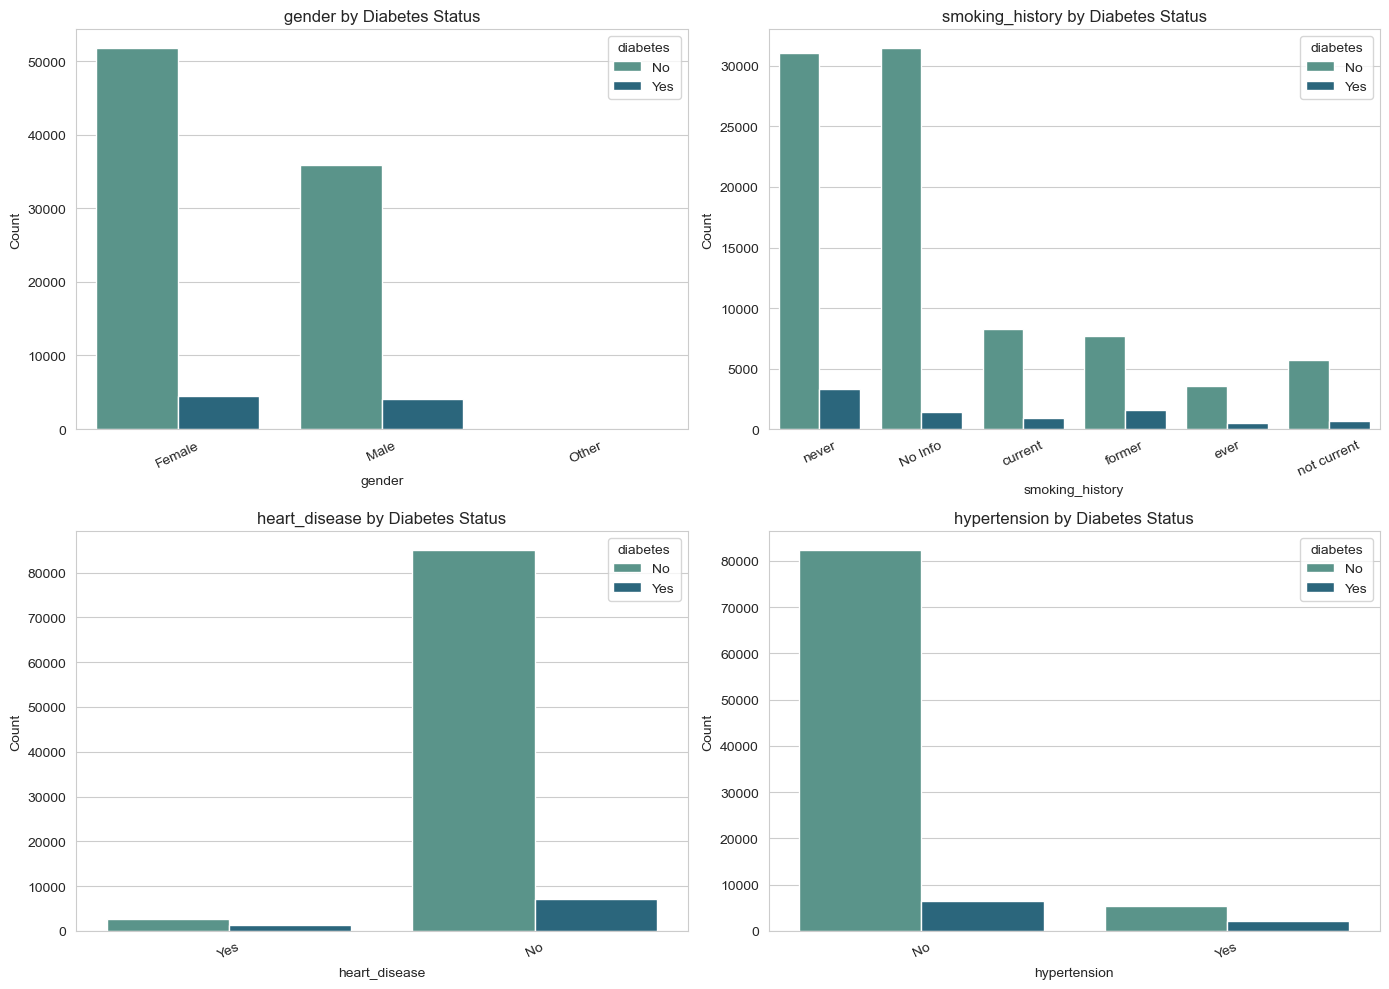

In [38]:
#categorical features by diabetes status

categorical_cols = ['gender', 'smoking_history', 'heart_disease', 'hypertension']
colors = sns.color_palette('crest', n_colors=2)

plt.figure(figsize=(14, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=col, data=df_plot, hue='diabetes', palette=colors)
    plt.title(f'{col} by Diabetes Status')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=25)
plt.tight_layout()
plt.savefig('visuals/categorical_distributions_by_diabetes.png')
plt.show()

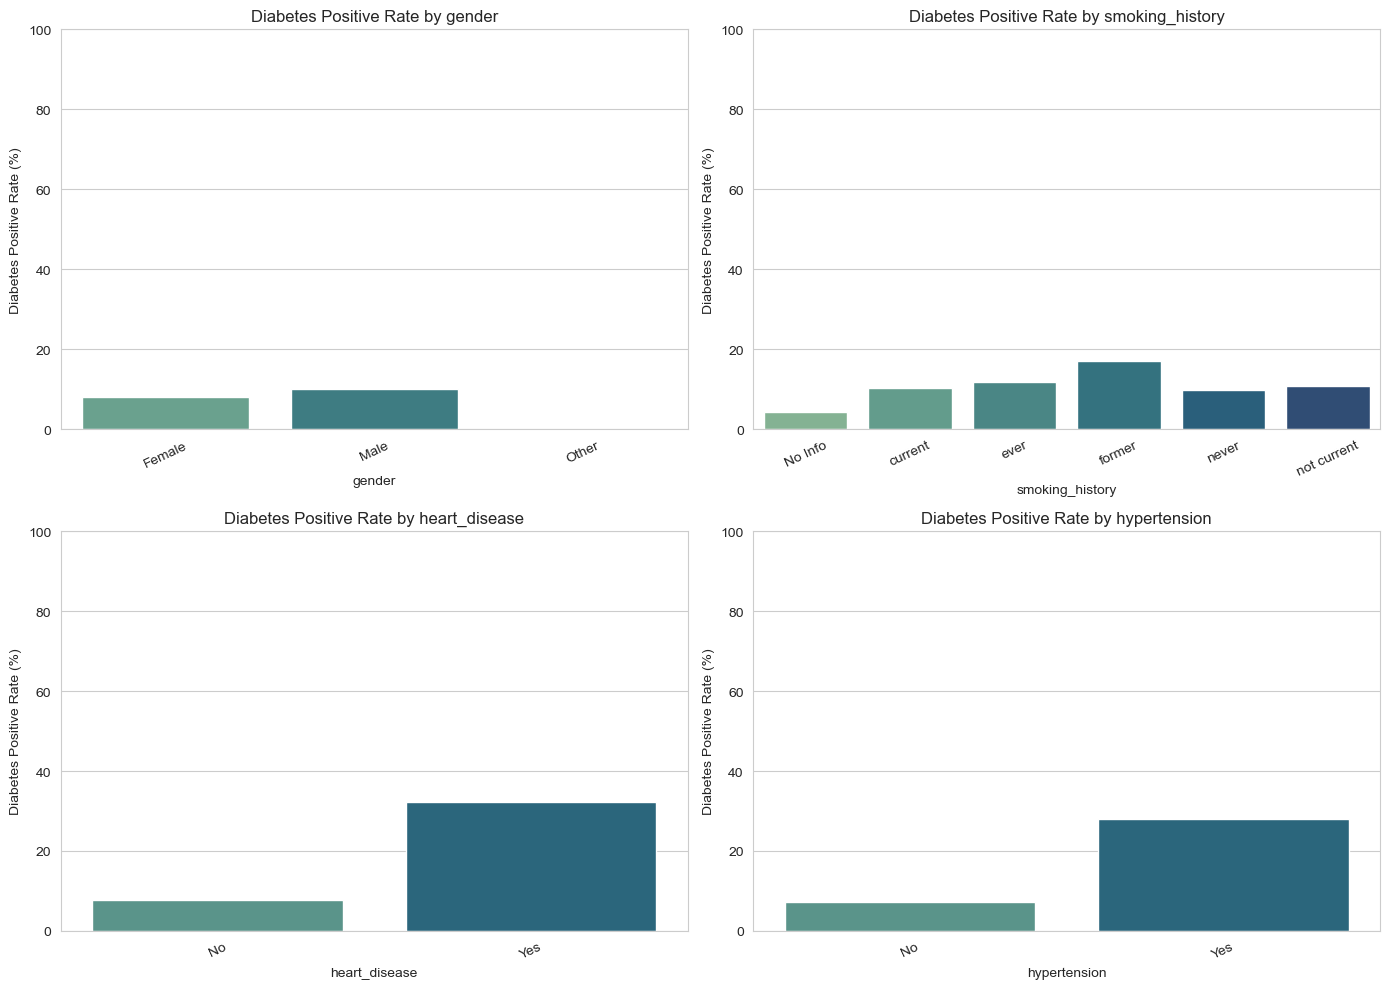

In [39]:
#diabetes positive rate by categorical features
categorical_cols = ['gender', 'smoking_history', 'heart_disease', 'hypertension']

plt.figure(figsize=(14, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    diabetes_rate = df_plot.groupby(col)['diabetes'].value_counts(normalize=True).unstack()
    if 'Yes' in diabetes_rate.columns:
        sns.barplot(x=diabetes_rate.index, y=diabetes_rate['Yes'] * 100, hue=diabetes_rate.index, palette='crest', legend=False)
        plt.ylabel('Diabetes Positive Rate (%)')
    else:
        plt.text(0.5, 0.5, 'No diabetic cases in this category', ha='center')
    plt.title(f'Diabetes Positive Rate by {col}')
    plt.xlabel(col)
    plt.ylim(0, 100)
    plt.xticks(rotation=25)
plt.tight_layout()
plt.savefig('visuals/diabetes_positive_rate_by_category.png', dpi=300, bbox_inches='tight')
plt.show()

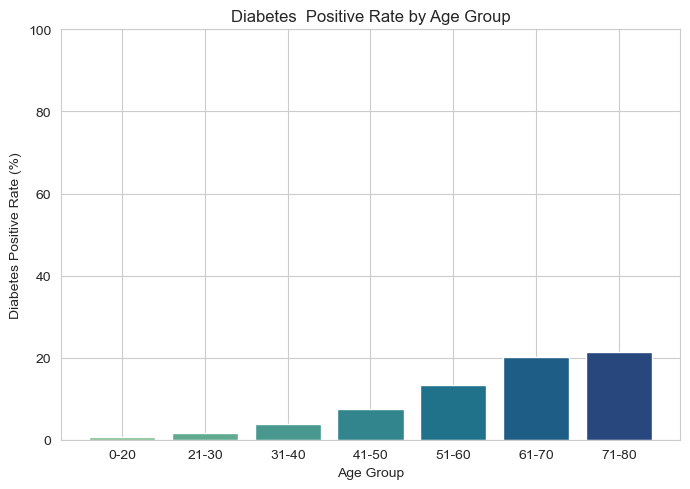

In [40]:
#diabetes positive rate by age
df_plot['age_group'] = pd.cut(df_plot['age'], bins=[0, 20, 30, 40, 50, 60, 70, 80], labels=[
    '0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80'])
age_rate = df_plot.groupby('age_group', observed=True)['diabetes'].value_counts(normalize=True).unstack()

plt.figure(figsize=(7, 5))
if 'Yes' in age_rate.columns:
    values = age_rate['Yes'] * 100
    colors = sns.color_palette('crest', n_colors=len(values))
    plt.bar(age_rate.index.astype(str), values, color=colors)
    plt.ylabel('Diabetes Positive Rate (%)')
else:
    plt.text(0.5, 0.5, 'No diabetic cases in any age group', ha='center')
plt.title('Diabetes  Positive Rate by Age Group')
plt.xlabel('Age Group')
plt.ylim(0, 100)
plt.tight_layout()
plt.savefig('visuals/diabetes_positive_rate_by_age_group.png', dpi=300, bbox_inches='tight')
plt.show()

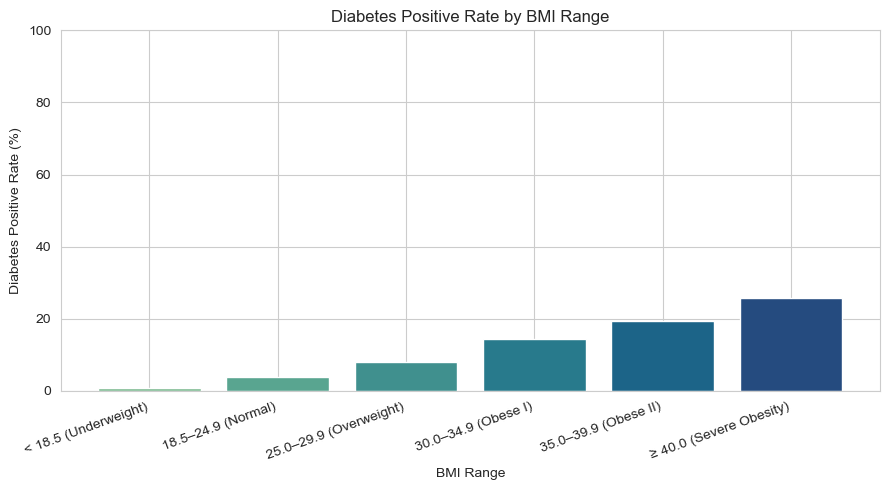

In [41]:
#diabetes positive rate by BMI
df_plot['bmi_range'] = pd.cut(df_plot['bmi'], bins=[0, 18.5, 25, 30, 35, 40, 100], labels=[
    '< 18.5 (Underweight)',
    '18.5–24.9 (Normal)',
    '25.0–29.9 (Overweight)',
    '30.0–34.9 (Obese I)',
    '35.0–39.9 (Obese II)',
    '≥ 40.0 (Severe Obesity)'])
bmi_rate = df_plot.groupby('bmi_range', observed=True)['diabetes'].value_counts(normalize=True).unstack()

plt.figure(figsize=(9, 5))
if 'Yes' in bmi_rate.columns:
    values = bmi_rate['Yes'] * 100
    colors = sns.color_palette('crest', n_colors=len(values))
    plt.bar(bmi_rate.index.astype(str), values, color=colors)
    plt.ylabel('Diabetes Positive Rate (%)')
else:
    plt.text(0.5, 0.5, 'No diabetic cases in any BMI group', ha='center')
plt.title('Diabetes Positive Rate by BMI Range')
plt.xlabel('BMI Range')
plt.ylim(0, 100)
plt.xticks(rotation=20, ha='right')
plt.tight_layout()
plt.savefig('visuals/diabetes_positive_rate_by_bmi_range.png', dpi=300, bbox_inches='tight')
plt.show()

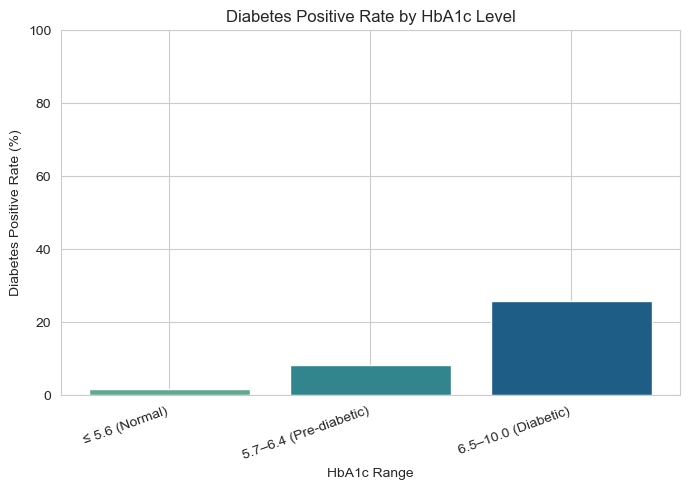

In [42]:
#diabetes positive rate by hba1c
df_plot['hba1c_range'] = pd.cut(df_plot['HbA1c_level'], bins=[0, 5.7, 6.4, 10], labels=[
        '≤ 5.6 (Normal)', '5.7–6.4 (Pre-diabetic)','6.5–10.0 (Diabetic)'])
hba1c_rate = df_plot.groupby('hba1c_range', observed=True)['diabetes'].value_counts(normalize=True).unstack()

plt.figure(figsize=(7, 5))
if 'Yes' in hba1c_rate.columns:
    values = hba1c_rate['Yes'] * 100
    colors = sns.color_palette('crest', n_colors=len(values))
    plt.bar(hba1c_rate.index.astype(str), values, color=colors)
    plt.ylabel('Diabetes Positive Rate (%)')
else:
    plt.text(0.5, 0.5, 'No diabetic cases in any HbA1c range', ha='center')
plt.title('Diabetes Positive Rate by HbA1c Level')
plt.xlabel('HbA1c Range')
plt.ylim(0, 100)
plt.xticks(rotation=20, ha='right')
plt.tight_layout()
plt.savefig('visuals/diabetes_positive_rate_by_hba1c_range.png', dpi=300, bbox_inches='tight')
plt.show()

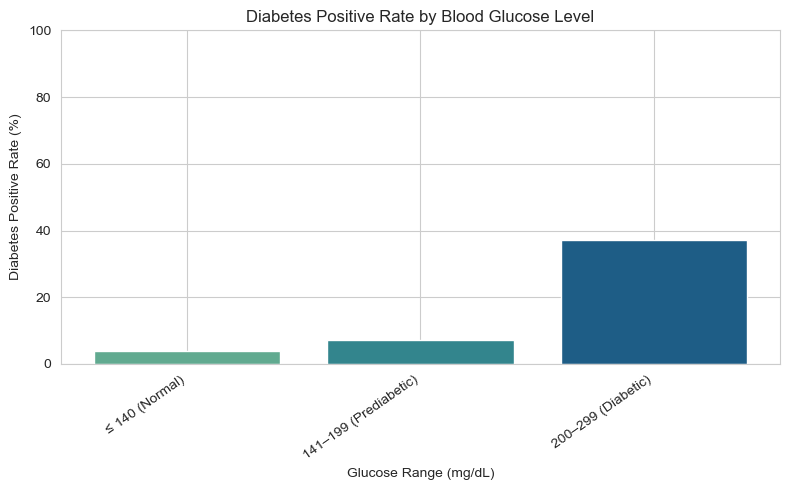

In [43]:
#diabetes positive rate by blood glucose levels
df_plot['glucose_range'] = pd.cut(df_plot['blood_glucose_level'], bins=[0, 140, 199, 300], labels=[
    '≤ 140 (Normal)', '141–199 (Prediabetic)','200–299 (Diabetic)'])
glucose_rate = df_plot.groupby('glucose_range', observed=True)['diabetes'].value_counts(normalize=True).unstack()

plt.figure(figsize=(8, 5))
if 'Yes' in glucose_rate.columns:
    values = glucose_rate['Yes'] * 100
    colors = sns.color_palette('crest', n_colors=len(values))
    plt.bar(glucose_rate.index.astype(str), values, color=colors)
    plt.ylabel('Diabetes Positive Rate (%)')
else:
    plt.text(0.5, 0.5, 'No diabetic cases in any glucose group', ha='center')
plt.title('Diabetes Positive Rate by Blood Glucose Level')
plt.xlabel('Glucose Range (mg/dL)')
plt.xticks(rotation=35, ha='right')
plt.ylim(0, 100)
plt.tight_layout()
plt.savefig('visuals/diabetes_positive_rate_by_glucose_range.png', dpi=300, bbox_inches='tight')
plt.show()


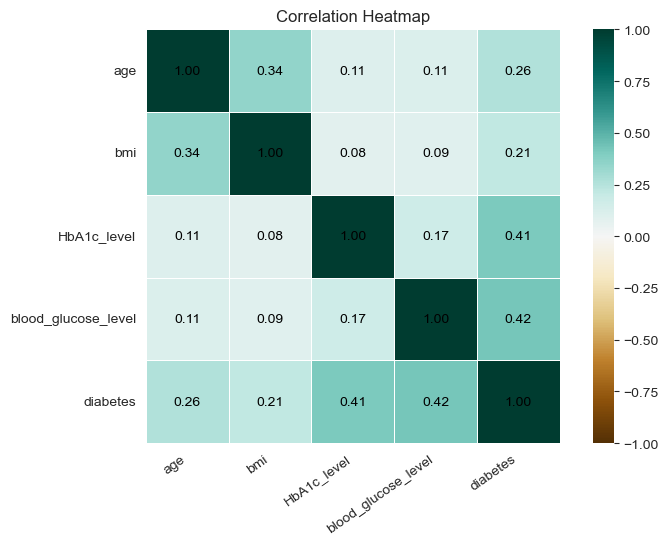

In [89]:
#correlation heatmap
numeric_diabetes = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']
corr_matrix = df[numeric_diabetes].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='BrBG', vmin=-1, vmax=1,
            linewidths=0.5, square=True, annot_kws={"color": "black", "fontsize": 10})
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.xticks(rotation=35, ha='right')
plt.savefig('visuals/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## Key Insights

### Target Distribution
- **Diabetes Prevalence**: Only **8.8%** of individuals in the dataset are diabetic.


### Categorical Variables & Diabetes Rates

  **Gender**
  - While more women are diabetic in total, this is due to their larger representation in the dataset.
  - When comparing within each gender, **men are slightly more likely to have diabetes**, though the difference is small.

  **Smoking History**
  - **Former smokers** have the highest diabetes rate compared to other groups.

  **Heart Disease**
  - Diabetes tends to **show up more often** in **people with heart disease**, highlighting a clear connection between the two conditions.

  **Hypertension**
  -  **Diabetes is more common among individuals with hypertension** than those without.



### Binned Numeric Features & Diabetes Rates

  **Age Group**
  - Diabetes rates increase steadily with age, especially after age 40.

  **BMI Range**
  - People in **higher BMI ranges** are **more likely** to have diabetes

  **HbA1c Level**
  - Diabetes becomes much more common as HbA1c levels move into the diabetic range, following the expected medical pattern.

  **Blood Glucose Level**
  - Diabetes rates **increase with rising glucose levels**, reaching **nearly 36%** among individuals in the **200-299 mg/dL** range.


### Correlation Matrix Highlights

| Feature               | Correlation with Diabetes |
|------------------------|---------------------------|
| **Blood Glucose Level** | **0.42** – highest        |
| **HbA1c Level**         | **0.41** – strong         |
| **Age**                | 0.26 – moderate           |
| **BMI**                | 0.21 – moderate               |

Among all features, **blood glucose** and **HbA1c levels** show the strongest correlation with diabetes, which aligns with how diabetes is clinically diagnosed.

---

## Modeling

In [105]:
#creating a copy of the dataset 
df_model = df.copy()

In [107]:
#enconding gender
le = LabelEncoder()
df_model['gender'] = le.fit_transform(df_model['gender'])

In [109]:
#enconding smoking_history
df_model = pd.get_dummies(df_model, columns=['smoking_history'], drop_first=True)

In [111]:
#splittling data
X = df_model.drop('diabetes', axis=1)
y = df_model['diabetes']

In [113]:
#training data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [115]:
#scaling numeral features
numeric_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

### Logistic Regression Modeling

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     17534
           1       0.89      0.63      0.74      1696

    accuracy                           0.96     19230
   macro avg       0.93      0.81      0.86     19230
weighted avg       0.96      0.96      0.96     19230

Confusion Matrix:
[[17400   134]
 [  625  1071]]
ROC AUC Score: 0.96


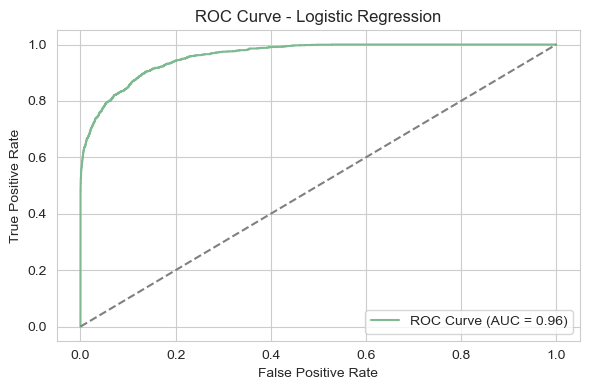

In [143]:
#Initializing and training the model
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

#making predictions
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]  #ROC

#evaluating
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

#roc
roc_score = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_score:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.tight_layout()
plt.savefig('visuals/logreg_roc_curve.png', dpi=300)
plt.show()

The logistic regression model achieved an overall accuracy of 96%, indicating strong ability to separate classes.

### Random Forest

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17534
           1       0.95      0.69      0.80      1696

    accuracy                           0.97     19230
   macro avg       0.96      0.84      0.89     19230
weighted avg       0.97      0.97      0.97     19230

Confusion Matrix:
[[17472    62]
 [  525  1171]]
ROC AUC Score: 0.96


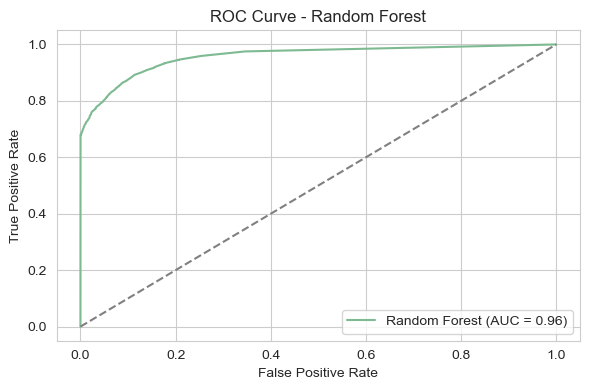

In [145]:
#Initializing and training the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

#making predictions
rf_pred = rf.predict(X_test)
rf_prob = rf.predict_proba(X_test)[:, 1]

#evaluating
print("Classification Report:")
print(classification_report(y_test, rf_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, rf_pred))

#ROC
rf_roc = roc_auc_score(y_test, rf_prob)
print(f"ROC AUC Score: {rf_roc:.2f}")

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_roc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.tight_layout()
plt.savefig('visuals/randomforest_roc_curve.png', dpi=300)
plt.show()

Both models performed very well, with a high ROC AUC score of 0.96, showing they can reliably tell apart diabetic and non-diabetic individuals.
However, Random Forest performed better overall. It was more accurate at finding diabetic cases, with higher recall (0.69 vs. 0.63) and F1-score (0.80 vs. 0.74).

Because of that, **Random Forest is the better choice for this task.**

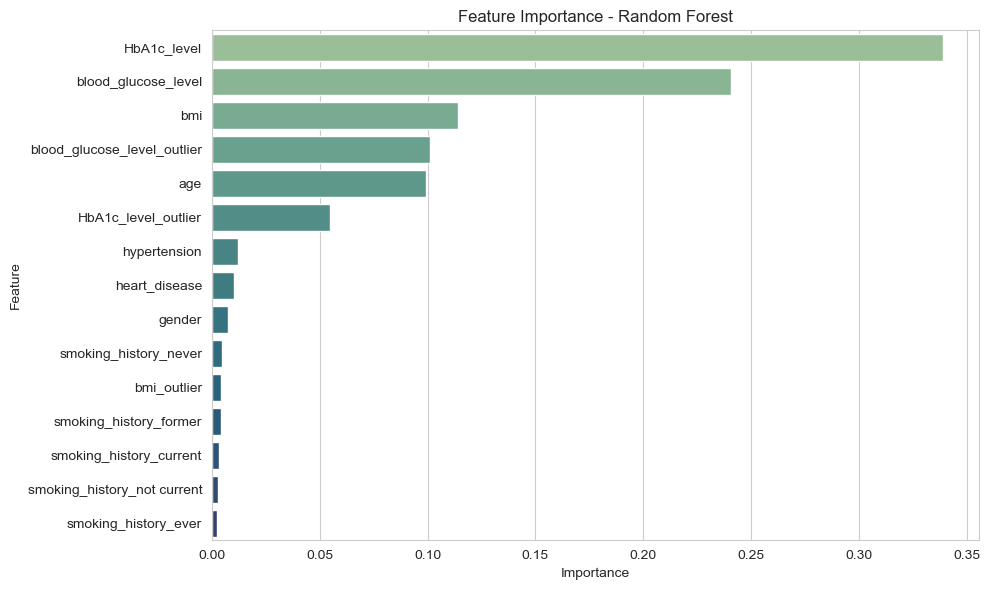

In [151]:
#important features
importances = rf.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', hue='Feature', palette='crest', legend=False)
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.savefig('visuals/randomforest_feature_importance.png', dpi=300)
plt.show()

The feature importance analysis shows that HbA1c_level and blood_glucose_level are the strongest predictors of diabetes, followed by BMI and age.
Outlier indicators also helped the model identify individuals with unusually high health risks.

Demographic features like gender and smoking history contributed less but still added some predictive valu.

---

## Conclusion

In this project, I explored a diabetes prediction dataset through data cleaning, exploratory analysis, and machine learning modeling.

This analysis could help support early detection efforts and improve decision-making in healthcare contexts.